In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats import f_oneway

import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1.	Data Exploration

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Tezda/age_gender.csv')
data

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


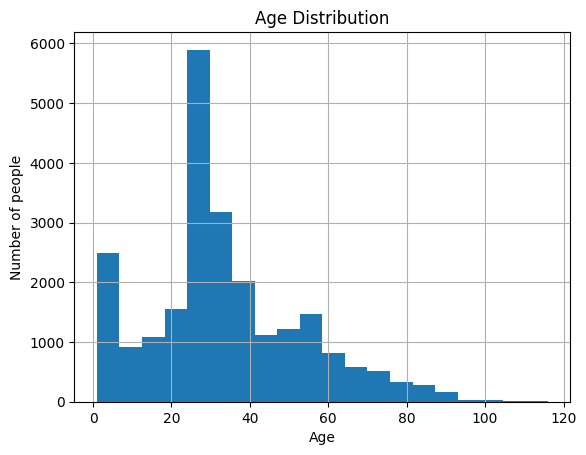

In [6]:
data.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Number of people')
plt.title('Age Distribution')
plt.show()

Here we see a high proportion of people range from 25 yrs to 35 yrs in the dataset.

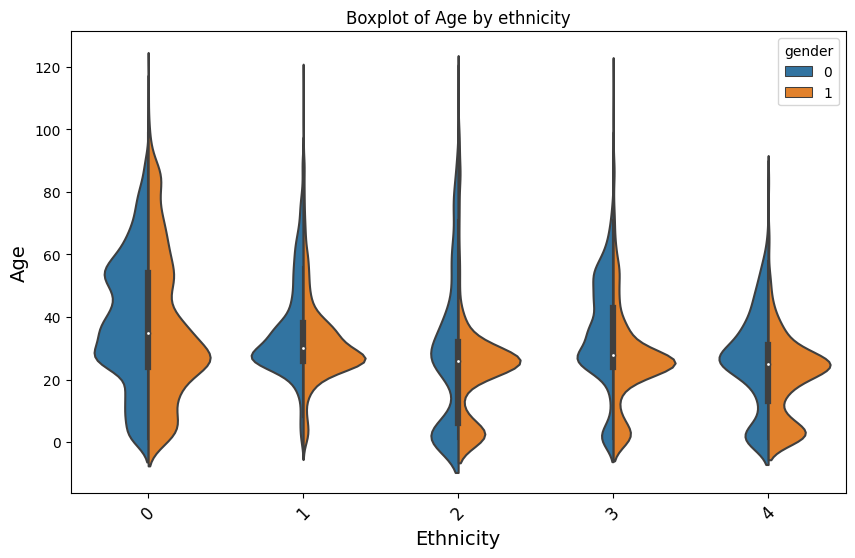

In [7]:
# Create a boxplot for Age of each ethnicity
plt.figure(figsize=(10, 6))
sns.violinplot(data=data, x='ethnicity', y='age',hue='gender',split=True)

plt.xlabel('Ethnicity', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.title('Boxplot of Age by ethnicity')


plt.xticks(rotation=45, fontsize=12)
plt.show()


In [8]:
covs1=['age', 'gender']
grouped_DX = [group_data[covs1] for group_name, group_data in data.groupby('ethnicity')]

f_statistic, p_value = f_oneway(*grouped_DX)
print("One-way ANOVA results:")
for i, stat in enumerate(f_statistic):
    print(f"{covs1[i]} F-statistic: {stat:.2f}, P-value: {p_value[i]:.0e}")

One-way ANOVA results:
age F-statistic: 403.77, P-value: 0e+00
gender F-statistic: 36.83, P-value: 1e-30


Here we see ethnicity 0 has the highest number of people. While the ratio of male/female is balanced in ethnicity 0, 1 and 4, there is a slight imbalance in ethnicity 2 and 3 across the age. Overall, we have a decent number of people across all ethnicity. Thus, we can make a histogram to check exact numbers.

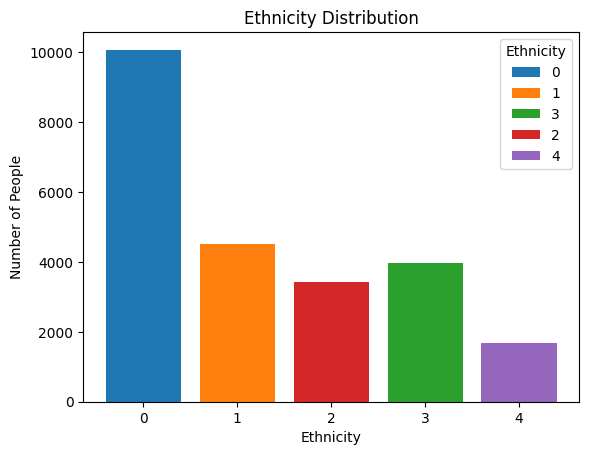

In [9]:
default_palette = sns.color_palette()

ethnicity_counts = data['ethnicity'].value_counts()
unique_ethnicities = ethnicity_counts.index
bars = plt.bar(unique_ethnicities, ethnicity_counts.values, color=default_palette)


plt.xlabel('Ethnicity')
plt.ylabel('Number of People')
plt.title('Ethnicity Distribution')
plt.legend(bars, unique_ethnicities, title='Ethnicity')
plt.show()

# 2.	Data Pre-processing:

In [95]:
duplicate_rows = data[data.duplicated(subset=['img_name'])]
print(f"Total duplicate rows: {len(duplicate_rows)}")

Total duplicate rows: 226


In [97]:
data.shape

(23705, 5)

In [100]:
data=data.drop_duplicates(subset=['img_name'])

In [101]:
data.shape

(23479, 5)

In [104]:
filtered_data = data[data['age'].map(data['age'].value_counts()) > 20]

In [103]:
#First I reshape all images to 48x48

target_size = (48, 48, 1)
reshaped_arrays = []

for row in filtered_data['pixels']:

    values = row.split()
    integer_array = np.array(values)
    integer_array1 = np.array([int(val) for val in integer_array])

    reshaped_array = np.resize(integer_array1, target_size)
    reshaped_arrays.append(reshaped_array)



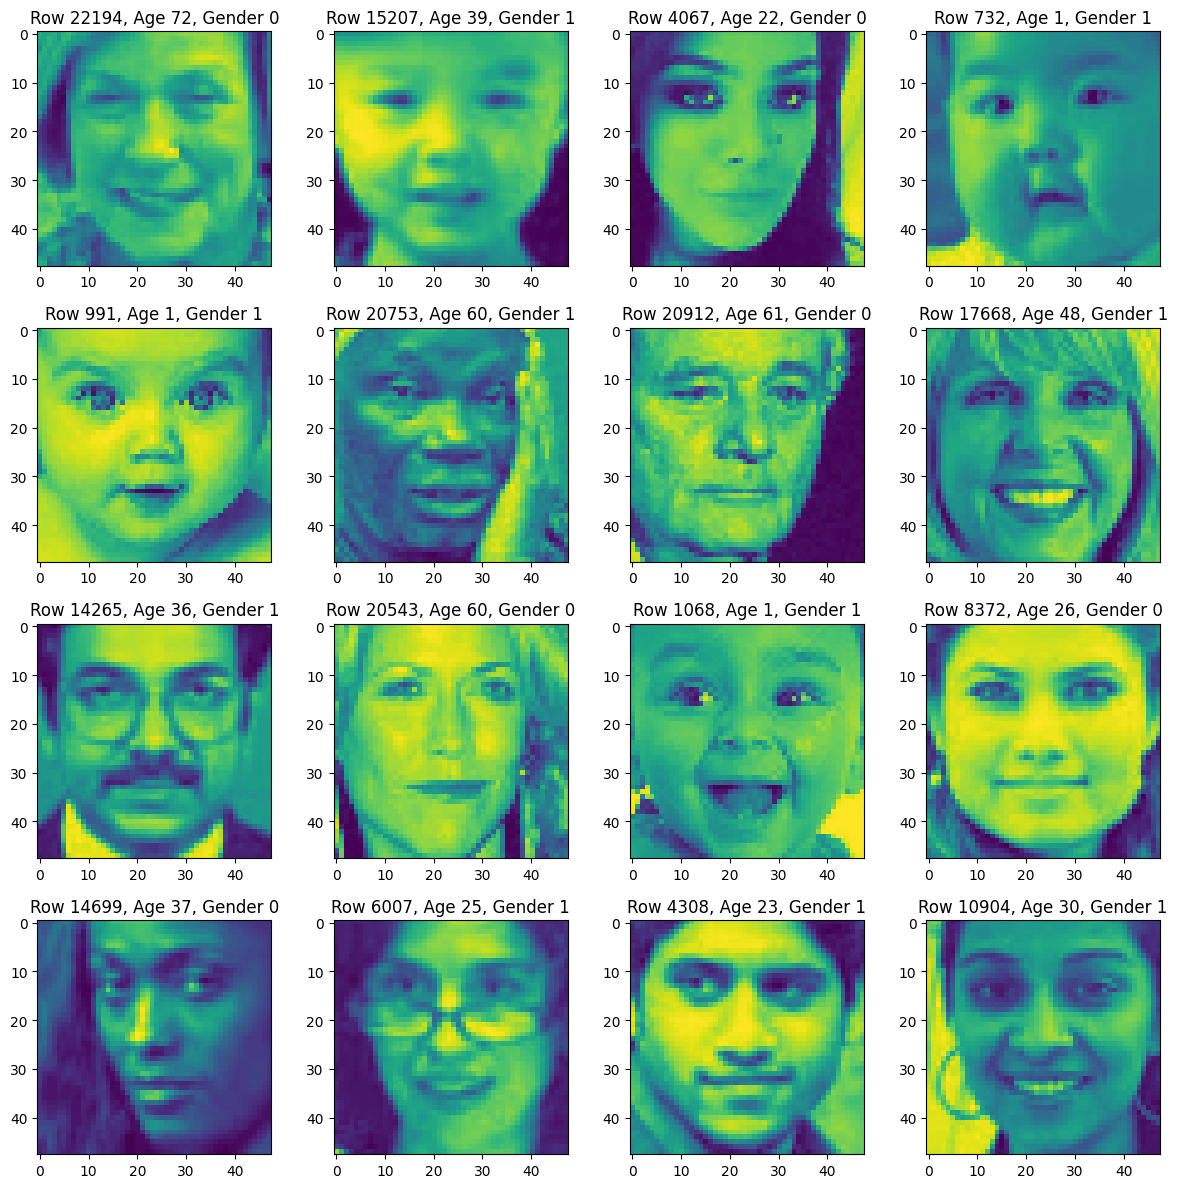

In [106]:
#Here I print 16 random images

total_rows = len(filtered_data['pixels'])
random_indices = np.random.choice(total_rows, 16, replace=False)

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
fig.tight_layout()


for idx, random_idx in enumerate(random_indices):
    img = reshaped_arrays[random_idx]
    age = data['age'][random_idx]
    gender = data['gender'][random_idx]

    subplot_row = idx // 4
    subplot_col = idx % 4
    ax[subplot_row, subplot_col].imshow(img)
    ax[subplot_row, subplot_col].title.set_text(f"Row {random_idx}, Age {age}, Gender {gender}")

plt.show()

# 3.	Model Development and training:

In [10]:
min_value = np.min(reshaped_arrays)
max_value = np.max(reshaped_arrays)

# Print the minimum and maximum values
print(f"Minimum Value: {min_value}")
print(f"Maximum Value: {max_value}")

Minimum Value: 0
Maximum Value: 255


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers import LeakyReLU

In [110]:
from sklearn.model_selection import train_test_split

x = np.array(reshaped_arrays, dtype=np.float32) / 255.0
y = filtered_data['age'].values


x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

In [117]:
input_shape = (48, 48, 1)
model = Sequential()


# Convolutional layers
model.add(Conv2D(16, (2, 2), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D())

# Flatten layer
model.add(Flatten())

model.add(Dropout(0.2))

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse','accuracy'])


history = model.fit(x_train, y_train, epochs=79, validation_data=(x_val, y_val), batch_size=300)


Epoch 1/79
55/55 [==============================] - 3s 20ms/step - loss: 638.9395 - mse: 638.9395 - accuracy: 0.0479 - val_loss: 424.0729 - val_mse: 424.0729 - val_accuracy: 0.0436
Epoch 2/79
55/55 [==============================] - 1s 12ms/step - loss: 415.4626 - mse: 415.4626 - accuracy: 0.0498 - val_loss: 396.2991 - val_mse: 396.2991 - val_accuracy: 0.0436
Epoch 3/79
55/55 [==============================] - 1s 14ms/step - loss: 390.0599 - mse: 390.0599 - accuracy: 0.0498 - val_loss: 372.3581 - val_mse: 372.3581 - val_accuracy: 0.0436
Epoch 4/79
55/55 [==============================] - 1s 14ms/step - loss: 369.6953 - mse: 369.6953 - accuracy: 0.0498 - val_loss: 353.9377 - val_mse: 353.9377 - val_accuracy: 0.0436
Epoch 5/79
55/55 [==============================] - 1s 14ms/step - loss: 352.0023 - mse: 352.0023 - accuracy: 0.0498 - val_loss: 341.2746 - val_mse: 341.2746 - val_accuracy: 0.0436
Epoch 6/79
55/55 [==============================] - 1s 14ms/step - loss: 339.1481 - mse: 339.14

# 4.	Evaluation:

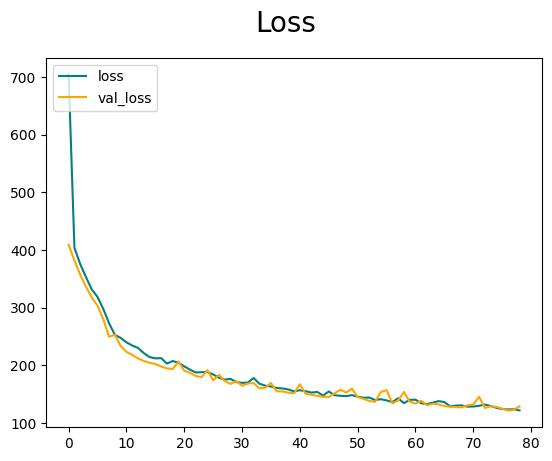

In [112]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

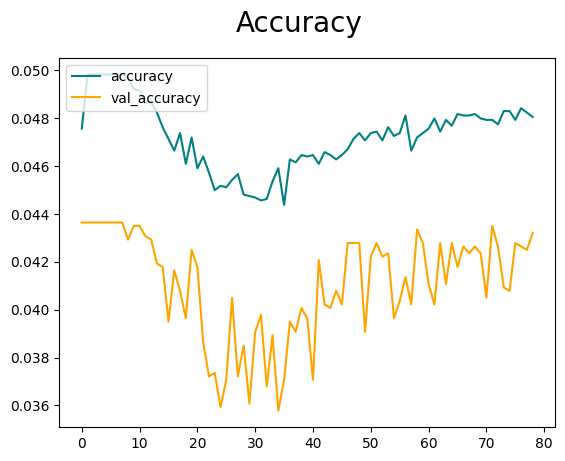

In [113]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [114]:
test1_loss, test_mse, test_accuracy = model.evaluate(x_val, y_val)

print(f'Test Loss: {test1_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

220/220 [==============================] - 1s 3ms/step - loss: 128.6933 - mse: 128.6933 - accuracy: 0.0432
Test Loss: 128.6933, Test Accuracy: 0.0432


In [116]:
import os
model.save(os.path.join('models','imageclassifier.h5'))